In [5]:
import random 
import time
import math
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.mllib.clustering import KMeans, KMeansModel
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import mean
from itertools import groupby, compress

from typing import Tuple, Sequence

sc.setLogLevel('INFO')

# sc.stop()
# conf = SparkConf().set("spark.python.profile", "true")
# conf = SparkConf().set("spark.driver.memory", "29G")
# sc = SparkContext(conf=conf)

# For reproducability of results
RANDOM_SEED = 301191

%matplotlib inline

sc.getConf().getAll()

[('spark.driver.host', 'spark-standalone.internal.cloudapp.net'),
 ('spark.driver.memory', '16G'),
 ('spark.app.id', 'local-1599860309958'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '45641'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
def parse_line(line):
    return tuple(map(float, line.strip().split()))

data = sc.textFile("a3.txt")
parsed_data = data.map(lambda line: parse_line(line))
parsed_data.cache()
parsed_data.take(5)

[(53920.0, 42968.0),
 (52019.0, 42206.0),
 (52570.0, 42476.0),
 (54220.0, 42081.0),
 (54268.0, 43420.0)]

In [7]:
def euclidean_dist(v1, v2):
    return math.sqrt(sum(map(lambda x_y: (x_y[0] - x_y[1])**2,  zip(v1, v2))))

def closest_centroid_point(row, centroids):
    distances = map(lambda centroid: (centroid, euclidean_dist(centroid, row)), centroids.value)
    return min(distances, key=lambda x: x[1])[0]
    
def closest_centroids(data, centroids):
    return data.map(lambda row: (*row, closest_centroid_point(row, centroids)))

def aggregate_means(rdd):
    df = rdd.toDF()
    df_tuples = df.groupBy(df[-1]).mean(*df.columns[:-1]).collect()
    return list(map(lambda row: (tuple(row[0]), row[1:]), df_tuples))
    
def calc_error(old_new_centroids):
    return sum(map(lambda old_new: euclidean_dist(old_new[0], old_new[1]), old_new_centroids))

In [6]:
def pkmeans(data, n, max_iterations=150, stop_distance=0.01):
    print(time.asctime(), "Started")
    init_centroids = data.takeSample(False, n, seed=RANDOM_SEED)
    centroids = sc.broadcast(init_centroids)
    
    iteration = 1
    error = float("inf")
    while error > stop_distance and iteration <= max_iterations:
        loop_start = time.time()
        closest_centroids_rdd = closest_centroids(data, centroids)
        old_new_centroids = aggregate_means(closest_centroids_rdd)
        error = calc_error(old_new_centroids)
        print("{3} Iteration #{0}\tDistance between old and new centroid: {1:.4f}\tIteration took: {2:.4f} sec".format(
                                                                iteration, error, time.time() - loop_start,
                                                                time.asctime()))
        centroids = sc.broadcast(list(zip(*old_new_centroids))[1])
        iteration += 1
    
    return centroids.value

In [7]:
centroids = pkmeans(parsed_data, 50)

Fri Sep 11 19:31:35 2020 Started
Fri Sep 11 19:31:37 2020 Iteration #1	Distance between old and new centroid: 99201.4481	Iteration took: 2.2175 sec
Fri Sep 11 19:31:38 2020 Iteration #2	Distance between old and new centroid: 54617.9496	Iteration took: 0.4932 sec
Fri Sep 11 19:31:38 2020 Iteration #3	Distance between old and new centroid: 40523.5178	Iteration took: 0.4717 sec
Fri Sep 11 19:31:39 2020 Iteration #4	Distance between old and new centroid: 25362.2890	Iteration took: 0.4027 sec
Fri Sep 11 19:31:39 2020 Iteration #5	Distance between old and new centroid: 11000.3877	Iteration took: 0.3887 sec
Fri Sep 11 19:31:39 2020 Iteration #6	Distance between old and new centroid: 6497.1862	Iteration took: 0.3460 sec
Fri Sep 11 19:31:40 2020 Iteration #7	Distance between old and new centroid: 6869.9935	Iteration took: 0.3455 sec
Fri Sep 11 19:31:40 2020 Iteration #8	Distance between old and new centroid: 7119.8780	Iteration took: 0.3522 sec
Fri Sep 11 19:31:40 2020 Iteration #9	Distance bet

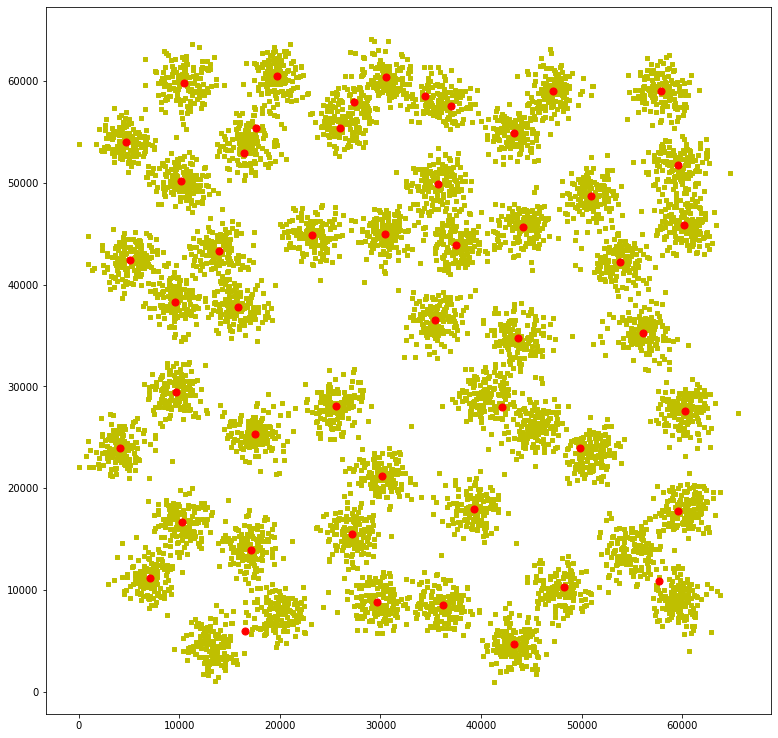

In [8]:
xdata, ydata = np.hsplit(array(parsed_data.collect()), 2)

x, y = np.hsplit(array(centroids), 2) 
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)


# x1, y1 = zip(*mllib_clusters.centers)

ax1.scatter(xdata, ydata, s=10, color='y', marker="s")
ax1.scatter(x, y, s=50, color='r', marker="o")
# ax1.scatter(x1, y1, s=35, color='k', marker="o")

In [9]:
fields_filter = [1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
len(fields_filter)

42

In [10]:
def parse_kdd_line_filter_fields(line):
    split_line = line.strip().split(',')
    return tuple(map(float, compress(split_line, fields_filter)))
    
    
kdd_data = sc.textFile("kddcup1999")
kdd_parsed_data_clean = kdd_data.map(parse_kdd_line_filter_fields)
kdd_parsed_data_clean.cache()

PythonRDD[219] at RDD at PythonRDD.scala:53

In [3]:
kdd_centroids = pkmeans(kdd_parsed_data_clean, 50)


Fri Sep 11 20:25:57 2020 Started  
Fri Sep 11 20:26:41 2020 Iteration #1   Distance between old and new centroid: 4137776.4055     Iteration took: 43.6707 sec  
Fri Sep 11 20:27:09 2020 Iteration #2   Distance between old and new centroid: 46121245.6556    Iteration took: 27.0637 sec  
Fri Sep 11 20:27:36 2020 Iteration #3   Distance between old and new centroid: 451674603.0614   Iteration took: 27.4725 sec  
Fri Sep 11 20:28:03 2020 Iteration #4   Distance between old and new centroid: 252770447.6514   Iteration took: 26.9551 sec  
Fri Sep 11 20:28:30 2020 Iteration #5   Distance between old and new centroid: 81932993.7698    Iteration took: 27.4007 sec  
Fri Sep 11 20:28:58 2020 Iteration #6   Distance between old and new centroid: 3009252.0272     Iteration took: 27.4065 sec  
Fri Sep 11 20:29:25 2020 Iteration #7   Distance between old and new centroid: 13641820.5162    Iteration took: 26.8601 sec  
Fri Sep 11 20:29:52 2020 Iteration #8   Distance between old and new centroid: 622

In [8]:
def calc_point_centroid_pairs(data, centroids) -> pyspark.rdd.RDD:
    return data.map(lambda point: (tuple(closest_centroid_point(point, centroids)), point))

def sum_of_squares_(centroid_points):
    s = 0
    points_ct = 0
    
    dim = len(centroid_points[0])    # get dimention of the point
    
    for centroid, points in centroid_points:
        centroid_arr = array(centroid)
        for point in points:
            s += euclidean_dist(point, centroid_arr)
            points_ct += 1    # count actual number of points in all the clusters
        points_ct -= 1        # required by the formula, reduce count by one
        
    return math.sqrt(s / (dim * points_ct))

def sum_of_squares_rmsstd(centroid_points):
    s = 0
    points_ct = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
        points_ct += 1
    
    return s, points_ct - 1  

def sum_of_squares_rs(centroid_points):
    s = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
    
    return s

def rmsstd(data: pyspark.rdd.RDD, centroids):
    dim = len(data.first())
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    s, n = point_centroid_pairs.groupByKey().map(sum_of_squares_rmsstd).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    return math.sqrt(s / (dim * n))

def rs(data: pyspark.rdd.RDD, centroids):
    g = data.mean()    # calc center of data
    sum_of_squares_total = data.map(lambda point: euclidean_dist(point, g)).sum()
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    sum_of_squres_clusters = point_centroid_pairs.groupByKey().map(sum_of_squares_rs).sum()
    
    return (sum_of_squares_total - sum_of_squres_clusters) / sum_of_squares_total
    


In [2]:
broad_kdd_centroids = sc.broadcast(kdd_centroids)
rmstd_kdd_custom = rmsstd(kdd_parsed_data_clean, broad_kdd_centroids)
rmstd_kdd_custom

6.574763669598161
